# This is our Training code convLSTM and RNN based methods. Please note we cannot uploade the huge dataset in submission so reading the files is not possible here. We can show demo in our system if needed. Also, this training takes a lot of time on PCs, and needs GPUs for training

In [ ]:
import xml.etree.ElementTree as ET
import requests
import os
import concurrent.futures
# datadownlaod
def fetch_xml(xml_url):
    response = requests.get(xml_url)
    if response.status_code != 200:
        print(f"Failed to fetch XML: {response.status_code}")
        return None
    return response.content

def parse_xml(xml_content):
    root = ET.fromstring(xml_content)
    namespace = {'s3': 'http://doc.s3.amazonaws.com/2006-03-01'}
    base_url = "https://storage.googleapis.com/quickdraw_dataset/"

    file_urls = []
    for content in root.findall(".//s3:Contents", namespace):
        key = content.find("s3:Key", namespace).text
        if key.startswith("sketchrnn/") and key.endswith(".npz") and not key.endswith(".full.npz"):
            file_urls.append(base_url + key)
    return file_urls

def download_file(file_url, download_folder):
    file_path = os.path.join(download_folder, os.path.basename(file_url))
    if os.path.exists(file_path):
        print(f"Already exists: {file_path}")
        return

    print(f"Downloading: {file_url}")
    response = requests.get(file_url)
    if response.status_code == 200:
        with open(file_path, "wb") as f:
            f.write(response.content)
    else:
        print(f"Failed to download: {file_url}")

def download_npy_files(xml_url, download_folder):
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    xml_content = fetch_xml(xml_url)
    if xml_content is None:
        return

    file_urls = parse_xml(xml_content)

    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        executor.map(lambda url: download_file(url, download_folder), file_urls)

xml_url = "https://storage.googleapis.com/quickdraw_dataset?prefix=sketchrnn/"
download_folder = "data"
download_npy_files(xml_url, download_folder)


Downloading: https://storage.googleapis.com/quickdraw_dataset/sketchrnn/The Eiffel Tower.npz
Downloading: https://storage.googleapis.com/quickdraw_dataset/sketchrnn/The Great Wall of China.npz
Downloading: https://storage.googleapis.com/quickdraw_dataset/sketchrnn/The Mona Lisa.npz
Downloading: https://storage.googleapis.com/quickdraw_dataset/sketchrnn/aircraft carrier.npz
Downloading: https://storage.googleapis.com/quickdraw_dataset/sketchrnn/airplane.npz
Downloading: https://storage.googleapis.com/quickdraw_dataset/sketchrnn/alarm clock.npz
Downloading: https://storage.googleapis.com/quickdraw_dataset/sketchrnn/ambulance.npz
Downloading: https://storage.googleapis.com/quickdraw_dataset/sketchrnn/angel.npz
Downloading: https://storage.googleapis.com/quickdraw_dataset/sketchrnn/animal migration.npz
Downloading: https://storage.googleapis.com/quickdraw_dataset/sketchrnn/ant.npz
Downloading: https://storage.googleapis.com/quickdraw_dataset/sketchrnn/anvil.npz
Downloading: https://storage

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Load a class
# data = np.load('data/camera.npz', allow_pickle=True, encoding='latin1')
# sample = data['train'][300]  # Pick a training sample

# # Convert dx, dy to x, y
# points = np.cumsum(sample[:, :2], axis=0)

# # Plot
# plt.figure(figsize=(4, 4))
# plt.plot(points[:, 0], -points[:, 1])
# plt.title("Training Sample")
# plt.axis("off")
# plt.show()


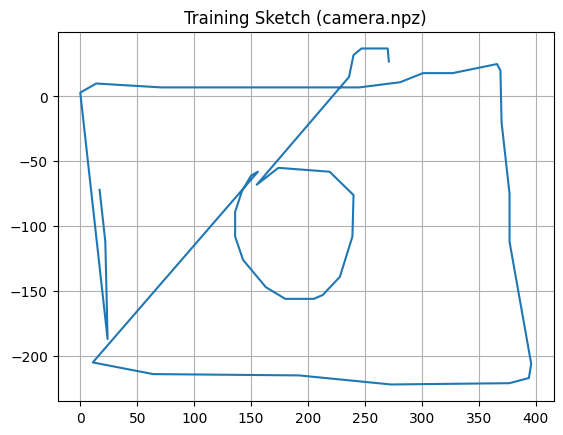

Raw training stroke (preprocessed):


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# MAX_SEQ_LEN = 130

# def preprocess_npz_sketch(sketch):
#     sketch = sketch.astype(np.float32)
#     sketch[:, 0] = np.cumsum(sketch[:, 0])
#     sketch[:, 1] = np.cumsum(sketch[:, 1])
#     sketch[:, 0] -= sketch[:, 0].mean()
#     sketch[:, 1] -= sketch[:, 1].mean()

#     if len(sketch) > MAX_SEQ_LEN:
#         sketch = sketch[:MAX_SEQ_LEN]
#     else:
#         padding = np.zeros((MAX_SEQ_LEN - len(sketch), 3), dtype=np.float32)
#         sketch = np.vstack([sketch, padding])

#     return sketch

# # Load training sketch
# data = np.load("data/camera.npz", allow_pickle=True, encoding="latin1")
# raw_train_stroke = data['train'][300]  # or any sample
# # train_processed = preprocess_npz_sketch(raw_train_stroke)

# # Plot it
# xy = np.cumsum(raw_train_stroke[:, :2], axis=0)
# plt.plot(xy[:, 0], -xy[:, 1])
# plt.title("Training Sketch (camera.npz)")
# plt.grid(True)
# plt.show()

# # Print a few values
# print("Raw training stroke (preprocessed):")



In [ ]:
# all import
import numpy as np
import os
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers, models


DATA_DIR = '/content/data'
MAX_CLASSES = 345
MAX_SAMPLES_PER_CLASS = 80000
MAX_SEQ_LEN = 130
POINT_DIM = 3


In [ ]:
def preprocess_stroke(stroke, max_len=MAX_SEQ_LEN):
    stroke = stroke.astype(np.float32)
    stroke[:, 0] = np.cumsum(stroke[:, 0])
    stroke[:, 1] = np.cumsum(stroke[:, 1])
    stroke[:, 0] -= stroke[:, 0].mean()
    stroke[:, 1] -= stroke[:, 1].mean()

    if len(stroke) > max_len:
        stroke = stroke[:max_len]
    else:
        # if stroke too short, we do fill with zero thing
        pad = np.zeros((max_len - len(stroke), 3), dtype=np.float32)
        stroke = np.vstack([stroke, pad])

    return stroke

def load_data(data_dir, max_classes, max_samples_per_class):
    # we only want some file that ends in .npz, no all files
    files = sorted([f for f in os.listdir(data_dir) if f.endswith('.npz')])[:max_classes]
    X, y = [], []

    for class_id, file in enumerate(files):
        data = np.load(os.path.join(data_dir, file), allow_pickle=True, encoding="latin1")
        for stroke in data['train'][:max_samples_per_class]:
            X.append(preprocess_stroke(stroke))
            y.append(class_id)

    X = np.array(X, dtype=np.float32)
    y = to_categorical(y, num_classes=max_classes)
    # mix X and y so not in same order, for better training beteer accuracy
    return shuffle(X, y, random_state=42)


In [ ]:

def build_model(seq_len=MAX_SEQ_LEN, input_dim=3, num_classes=MAX_CLASSES):
    inputs = layers.Input(shape=(seq_len, input_dim))

    x_lstm = layers.Masking(mask_value=0.0)(inputs)
    x_lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x_lstm)
    x_lstm = layers.Bidirectional(layers.LSTM(64))(x_lstm)

    x_cnn = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(inputs)
    x_cnn = layers.BatchNormalization()(x_cnn)
    x_cnn = layers.GlobalMaxPooling1D()(x_cnn)

    x = layers.Concatenate()([x_lstm, x_cnn])
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

X, y = load_data(DATA_DIR, MAX_CLASSES, MAX_SAMPLES_PER_CLASS)
split = int(0.9 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

callbacks = [
    ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=256,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 92s 47ms/step - accuracy: 0.4640 - loss: 2.0627 - val_accuracy: 0.7369 - val_loss: 0.9457 - learning_rate: 0.0010
Epoch 2/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 83s 47ms/step - accuracy: 0.7250 - loss: 0.9806 - val_accuracy: 0.7797 - val_loss: 0.7912 - learning_rate: 0.0010
Epoch 3/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 83s 47ms/step - accuracy: 0.7678 - loss: 0.8288 - val_accuracy: 0.8007 - val_loss: 0.7187 - learning_rate: 0.0010
Epoch 4/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 144s 48ms/step - accuracy: 0.7913 - loss: 0.7436 - val_accuracy: 0.8170 - val_loss: 0.6617 - learning_rate: 0.0010
Epoch 5/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 144s 49ms/step - accuracy: 0.8076 - loss: 0.6900 - val_accuracy: 0.8175 - val_loss: 0.6549 - learning_rate: 0.0010
Epoch 6/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 141s 49ms/step - accuracy: 0.8169 - loss: 0.6524 - val_accuracy: 0.8268 - val_loss: 0.6276 - learning_rate: 0.0010
Epoch 7/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 83s 47ms/step - acc

In [ ]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation Accuracy:", val_acc)

model.save("best_model_yomama.keras")


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8495 - loss: 0.5524
Validation Accuracy: 0.84961998462677


In [ ]:
import os

files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.npz')])[:MAX_CLASSES]
class_names = [f.replace('.npz', '') for f in files]

with open("classes.txt", "w") as f:
    for name in class_names:
        f.write(name + "\n")

print("Saved classes.txt ✅")


Saved classes.txt ✅


In [ ]:
import numpy as np
import random
import tensorflow as tf

model = tf.keras.models.load_model("best_model_yomama.keras")

with open("classes.txt") as f:
    CLASS_NAMES = [line.strip() for line in f.readlines()]

print("Available classes:", CLASS_NAMES)

chosen_class = "anvil"
file_path = f"/content/data/{chosen_class}.npz"
data = np.load(file_path, allow_pickle=True, encoding="latin1")

# we just pick one sketch from class data, not all of them for checking(infereing)
sample = random.choice(data["train"])

print(f"\nSelected sample from class: {chosen_class}")
print("Raw shape:", sample.shape)
print(sample)
print("\n")

def normalize_and_pad(sketch, max_len=130):
    sketch = sketch.astype(np.float32)
    sketch[:, 0] = np.cumsum(sketch[:, 0])
    sketch[:, 1] = np.cumsum(sketch[:, 1])
    sketch[:, 0] -= sketch[:, 0].mean()
    sketch[:, 1] -= sketch[:, 1].mean()

    if len(sketch) > max_len:
        sketch = sketch[:max_len]
    else:

        pad = np.zeros((max_len - len(sketch), 3), dtype=np.float32)
        sketch = np.vstack([sketch, pad])

    return sketch.reshape(1, max_len, 3)

processed = normalize_and_pad(sample)
print("processed input fed to the model")
print(processed)
print(processed.shape)
probs = model.predict(processed)[0]
top3 = np.argsort(probs)[-3:][::-1]

print("\n✅ Model Prediction:")
for idx in top3:
    print(f"{CLASS_NAMES[idx]}: {probs[idx]*100:.2f}%")
